In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import keras
from keras.preprocessing import image
from keras import regularizers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax

In [ ]:
pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.1 MB/s eta 0:00:00


In [ ]:
import opendatasets as od
import pandas
#weiya818
#24d636b51e5fc8edf57c030a556b0b04
od.download("https://www.kaggle.com/datasets/ansuld/fer2013plus-me")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: weiya818
Your Kaggle Key: ··········


100%|██████████| 36.2M/36.2M [00:03<00:00, 11.5MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#Codes cited from EECE571T Assignment 3
def dict_to_device(orig, device):
    new = {}
    for k,v in orig.items():
        new[k] = v.to(device)
    return new

def plot_images(img, ax):
    grid_img = torchvision.utils.make_grid(img)
    npimg = grid_img.numpy()

    if npimg.shape[0] == 3:
        npimg = np.transpose(npimg, (1, 2, 0))
    ax.imshow(npimg)
    ax.axis('off')


def tuple_to_dict(batch_tuple):
    batch_dict = {}
    batch_dict['image'] = torch.tensor(batch_tuple[0])
    batch_dict['label'] = torch.tensor(batch_tuple[1])
    return batch_dict

def move_to_cuda(x):
  x_cuda = tuple([torch.from_numpy(arr).cuda() for arr in x])
  return x_cuda

In [ ]:
train_dir = "/content/fer2013plus-me/train"
test_dir = "/content/fer2013plus-me/test"
validation_dir="/content/fer2013plus-me/val"
img_size=48

In [ ]:
train_datagen = ImageDataGenerator(
                                         width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                        )
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_iter = train_datagen.flow_from_directory(
    directory = train_dir,
    target_size = (img_size,img_size),
    batch_size = 128,
    class_mode = "categorical",
    subset = "training"
)
validation_iter = validation_datagen.flow_from_directory(
    directory = validation_dir,
    target_size = (img_size, img_size),
    batch_size = 128,
    class_mode = 'categorical'
)
test_iter = test_datagen.flow_from_directory( directory = test_dir,
    target_size = (img_size,img_size),
    batch_size = 128,
    class_mode = "categorical"
)

Found 28561 images belonging to 8 classes.
Found 3579 images belonging to 8 classes.
Found 3574 images belonging to 8 classes.


In [ ]:
#Code structure for ViT is from EECE571T A3, changes are made here
import torch
import torch.nn as nn
from einops.layers.torch import Rearrange
import math

class ViT(nn.Module):
    def __init__(self):
        super(ViT, self).__init__()
        hidden_dim = 512
        embedding_dim = 512
        drop_out_prob = 0.15
        num_layers = 6
        image_size = 48
        patch_size = 12
        num_classes = 8
        num_heads = 8

        num_patches = (image_size // patch_size) ** 2

        # Start with a patch_embedding layer to divide image into patches and
        # convert each patch into vector embeddings
        self.patch_embedding = nn.Sequential(
            nn.Conv2d(3, embedding_dim, kernel_size=patch_size, stride=patch_size),
            nn.BatchNorm2d(embedding_dim),
            nn.ReLU(),
            Rearrange('b c h w -> b (h w) c')
        )

        # Append a class token to image tokens
        self.class_embedding = nn.Parameter(torch.randn(1, 1, embedding_dim))

        # Add positional encodings
        self.position_embedding = nn.Parameter(torch.randn(1, num_patches + 1, embedding_dim), requires_grad=False)
        pos = torch.arange(0, num_patches+1, dtype=torch.float32).unsqueeze(1)
        div = torch.exp(torch.arange(0, embedding_dim, 2, dtype=torch.float32) * -(math.log(10000.0) / embedding_dim))
        self.position_embedding[:, :, 0::2] = torch.sin(pos * div)
        self.position_embedding[:, :, 1::2] = torch.cos(pos * div)

        # Apply dropout
        self.dropout = nn.Dropout(drop_out_prob)

        # Use a transformer encoder to calculate the attention weights
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads, dim_feedforward=1024, dropout=drop_out_prob),
            num_layers=num_layers
        )

        # Identity layer to select the class token
        self.to_cls_token = nn.Identity()

        # Apply an MLP head on the class token to predict the emotion
        self.mlp_head = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(drop_out_prob),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(drop_out_prob),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, input_dict):
      x = input_dict
      x = x.permute(0, 3, 1, 2)
      x = self.patch_embedding(x)
      x = torch.cat((self.class_embedding.repeat(x.shape[0], 1, 1), x), dim=1)
      x = x + self.position_embedding[:, :x.shape[1], :]
      x = self.dropout(x)

      x = x.permute(1, 0, 2)
      x = self.transformer_encoder(x)
      x = x.permute(1, 0, 2)

      # Select the class token and predict the output
      x = self.to_cls_token(x[:, 0])
      output = self.mlp_head(x)
      logits = nn.functional.log_softmax(output, dim=1)

      return {'label': logits}


network = ViT().to('cuda')

In [ ]:
total_params = sum(p.numel() for p in network.parameters())
print(f'The model has {total_params:,} parameters.')

The model has 13,378,056 parameters.


In [ ]:
def my_loss_function(predicted_index, target_index):
  loss = nn.CrossEntropyLoss()(predicted_index, target_index.long())

  return loss

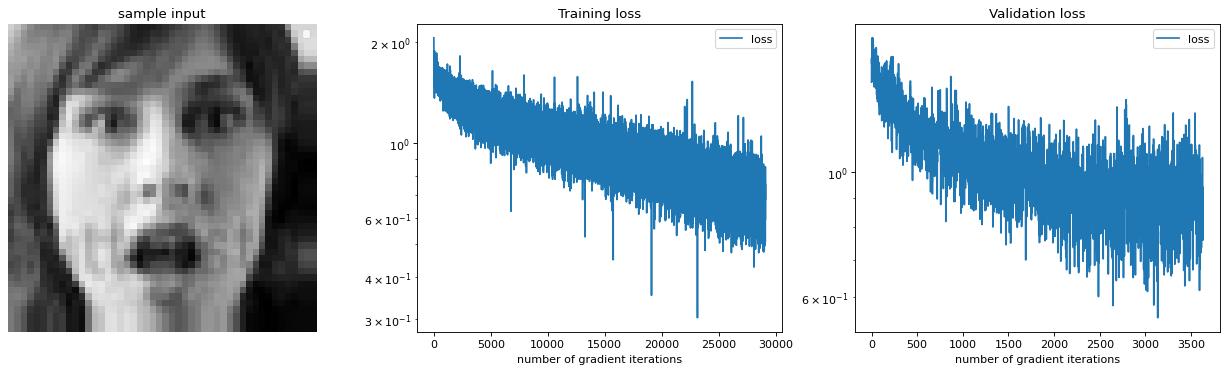

Validation epoch 129, iteration 20 of 28 (71 %), loss=0.9387


In [ ]:
#Codes structure from EECE571T Assignment 3, changes applied
import torch.optim as optim
from IPython import display

fig = plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')
axes = fig.subplots(1,3)

optimizer = optim.Adam(network.parameters(), lr=0.0001)

num_epochs = 130
train_losses = []
val_losses = []

for e in range(num_epochs):
    train_iter = iter(train_iter)
    network.train()
    for i in range(len(train_iter)):
        batch_cpu = next(train_iter)
        batch_gpu = move_to_cuda(batch_cpu)
        batch_dict = tuple_to_dict(batch_gpu)

        pred = network(batch_dict['image'])
        pred_cpu = dict_to_device(pred, 'cpu')

        loss = nn.CrossEntropyLoss()(pred_cpu['label'], batch_dict['label'].cpu())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        if i%100==0:
            axes[0].cla()
            axes[1].cla()

            # plot some sample image inputs
            plot_images(torch.from_numpy(batch_cpu[0][0:1]), ax=axes[0])
            axes[0].legend()
            axes[0].set_title('sample input')

            # plot the training error on a log plot
            axes[1].plot(train_losses, label='loss')
            axes[1].set_yscale('log')
            axes[1].set_title('Training loss')
            axes[1].set_xlabel('number of gradient iterations')
            axes[1].legend()

            # clear output window and display updated figure
            display.clear_output(wait=True)
            display.display(plt.gcf())
            print("Training epoch {}, iteration {} of {} ({} %), loss={:0.4f}".format(e, i, len(train_iter), 100*i//len(train_iter), train_losses[-1]))

    val_iter = iter(validation_iter)
    network.eval()
    for i in range(len(val_iter)):
        batch_cpu = next(val_iter)
        batch_gpu = move_to_cuda(batch_cpu)
        batch_dict = tuple_to_dict(batch_gpu)

        pred = network(batch_dict['image'])
        pred_cpu = dict_to_device(pred, 'cpu')

        # calculate the loss
        with torch.no_grad():
            loss = nn.CrossEntropyLoss()(pred_cpu['label'], batch_dict['label'].cpu())
            val_losses.append(loss.item())

        if i%10==0:
            axes[2].cla()

            # plot the validation error on a log plot
            axes[2].plot(val_losses, label='loss')
            axes[2].set_yscale('log')
            axes[2].set_title('Validation loss')
            axes[2].set_xlabel('number of gradient iterations')
            axes[2].legend()

            # clear output window and diplay updated figure
            display.clear_output(wait=True)
            display.display(plt.gcf())
            print("Validation epoch {}, iteration {} of {} ({} %), loss={:0.4f}".format(e, i, len(val_iter), 100*i//len(val_iter), val_losses[-1]))
plt.close('all')

In [ ]:
def get_accuracy(network, data_loader):
    network.eval()
    iterator = iter(data_loader)
    correct = 0
    total = 0
    for i in range(len(iterator)):
        batch_cpu = next(iterator)
        batch_gpu = move_to_cuda(batch_cpu)
        batch_dict = tuple_to_dict(batch_gpu)

        pred = network(batch_dict['image'])['label'].argmax(dim=1, keepdim=True)
        correct += pred.eq(batch_dict['label'].argmax(dim=1, keepdim=True).view_as(pred)).sum().item()
        total += pred.shape[0]

    return correct / total

In [ ]:
#130epoch
print("Train accuracy is: ", get_accuracy(network, train_iter))
print("Validation accuracy is: ", get_accuracy(network, validation_iter))
print("Test accuracy is: ", get_accuracy(network, test_iter))

<ipython-input-7-344152ba5cfc>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_dict['image'] = torch.tensor(batch_tuple[0])
<ipython-input-7-344152ba5cfc>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_dict['label'] = torch.tensor(batch_tuple[1])


Train accuracy is:  0.8003921431322433
Validation accuracy is:  0.7116512992455993
Test accuracy is:  0.7129266927811976


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
torch.save(network.state_dict(), '/content/drive/MyDrive/transformer_model_fer_130epoch.pth')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model_new = ViT().to('cuda')
model_new.load_state_dict(torch.load('/content/drive/MyDrive/transformer_model_fer_130epoch.pth'))

<All keys matched successfully>

In [ ]:
#130 epoch
print("Train accuracy is: ", get_accuracy(model_new, train_iter))
print("Validation accuracy is: ", get_accuracy(model_new, validation_iter))
print("Test accuracy is: ", get_accuracy(model_new, test_iter))

<ipython-input-7-936e959eef95>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_dict['image'] = torch.tensor(batch_tuple[0])
<ipython-input-7-936e959eef95>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_dict['label'] = torch.tensor(batch_tuple[1])


Train accuracy is:  0.7893981303175659
Validation accuracy is:  0.7175188600167645
Test accuracy is:  0.7168438724118634


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
torch.save(network.state_dict(), '/content/drive/MyDrive/model_trans_fer_V2.pth')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# model_new = ViT().to('cuda')
# model_new.load_state_dict(torch.load('/content/drive/MyDrive/model_trans_fer_V2.pth'))

<All keys matched successfully>